In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and further clean data
data = pd.read_csv("data/Algerian_forest_fires_dataset_CLEANED.csv")
# Remove NAN rows
data = data.dropna(axis=0)
# Drop the first messy column
data = data.drop(["Unnamed: 0"], axis=1)

In [3]:
# Define X, y
y = data["Classes"]
X = data.drop("Classes", axis=1)
# Random forest have trouble with string, so one hot encode:
# "Bejaia" -> 0, "Sidi-Bel Abbes" -> 1
# "notfire" -> 0, "fire" ->1
X["Region"][X["Region"] == "Bejaia"] = 0
X["Region"][X["Region"] == "Sidi-Bel Abbes"] = 1
y[y == "notfire"] = 0
y[y == "fire"] = 1
y = y.astype(int)
# Train test split on 1/3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
## Grid search cross validation
# Define param_grid
param_grid = {"n_estimators" : (10**np.linspace(0, 2, 40)).astype(int),
              "max_depth" : [1,2,3,4,5]}
# Define random forest model
rf_model = RandomForestClassifier(random_state=42)

In [5]:
# Grid search cross validation
grid = GridSearchCV(rf_model, param_grid, scoring="recall", cv=10)
grid.fit(X_train, y_train)
# Print best result
grid.best_params_, grid.best_score_

({'max_depth': 1, 'n_estimators': 5}, 0.9875)

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean_test_score'>

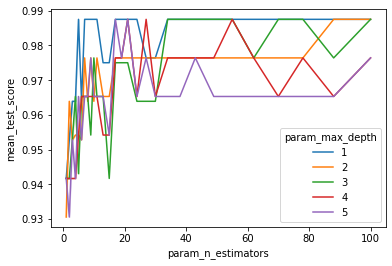

In [6]:
cv_results = pd.DataFrame(grid.cv_results_)

plt.figure(figsize=(6,4))
sns.lineplot("param_n_estimators", "mean_test_score", data=cv_results, hue="param_max_depth", palette="tab10")